In [256]:
import os
import random
import numpy as np
from glob import glob
import scipy.io
import shutil
import zipfile
from PIL import Image,ImageOps
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [257]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [258]:
train_low_light_images=sorted(glob("/content/drive/MyDrive/Colab Notebooks/low/*"))[:MAX_TRAIN_IMAGES]
val_low_light_images=sorted(glob("/content/drive/MyDrive/Colab Notebooks/low/*"))[MAX_TRAIN_IMAGES:]

print("Train Images:", len(train_low_light_images))
print("Validation Images:", len(val_low_light_images))

Train Images: 400
Validation Images: 85


In [259]:
from PIL import Image
import os
import numpy as np

def convert_images_to_vector(folder_path, target_size=(28, 28)):
  images = []
  for filename in os.listdir(folder_path):
    if filename.lower().endswith((".jpg", ".jpeg", ".png", ".bmp")):
      image_path = os.path.join(folder_path, filename)
      try:
        img = Image.open(image_path)
        if img.mode != 'L':
          img = img.convert('L')
        img = img.resize(target_size, resample=Image.LANCZOS)
        img_array = np.array(img)
        images.append(img_array)
      except (IOError, OSError) as e:
        print(f"Error opening image {filename}: {e}")

  image_vector = np.array(images)
  return image_vector

folder_path = "/content/drive/MyDrive/Colab Notebooks/low/"
image_vector = convert_images_to_vector(folder_path)

print(f"Image vector shape: {image_vector.shape}")

Image vector shape: (485, 28, 28)


In [261]:
MAX_TRAIN_IMAGES=400
train_low_light_images=image_vector[:MAX_TRAIN_IMAGES]
val_low_light_images=image_vector[MAX_TRAIN_IMAGES:]

print("Train Images:", (train_low_light_images.shape))
print("Validation Images:", (val_low_light_images.shape))

Train Images: (400, 28, 28)
Validation Images: (85, 28, 28)


In [262]:
train_dataset=(train_low_light_images)
val_dataset=(val_low_light_images)

print((train_dataset.shape))
print((val_dataset.shape))

(400, 28, 28)
(85, 28, 28)


In [264]:
noise_factor = 0.1

train_dataset_noise = train_dataset + noise_factor * np.random.normal(loc = 0., scale = 1., size = train_dataset.shape)
val_dataset_noise = val_dataset + noise_factor * np.random.normal(loc = 0., scale = 1., size = val_dataset.shape)

In [265]:
train_dataset_noise.shape

(400, 28, 28)

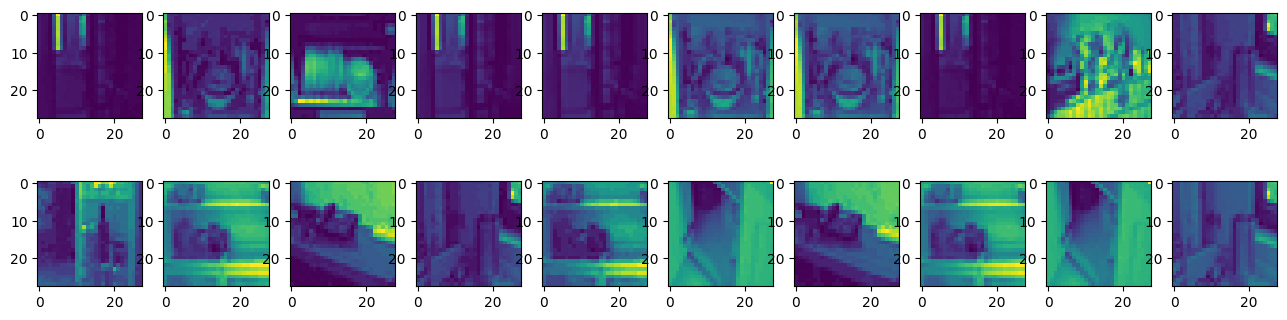

In [266]:
fig, axes = plt.subplots(2,10, figsize = (16,4))

count = 0
for i in range(2):
    for j in range(10):
        axes[i,j].imshow(train_dataset_noise[count])
        count+=1

In [267]:
train_dataset = train_dataset.reshape(train_dataset.shape[0], 28 ,28, 1)
val_dataset = val_dataset.reshape(val_dataset.shape[0], 28,28,1)

train_dataset_noise = train_dataset_noise.reshape(train_dataset_noise.shape[0], 28 ,28, 1)
val_dataset_noise = val_dataset_noise.reshape(val_dataset_noise.shape[0], 28,28,1)

train_dataset.shape, train_dataset_noise.shape

((400, 28, 28, 1), (400, 28, 28, 1))

In [268]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, Dense, UpSampling2D, BatchNormalization
from keras.callbacks import ModelCheckpoint

import tensorflow as tf

encoder_input = Input(shape = train_dataset.shape[1:])
x = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(encoder_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size = (2,2), padding = 'same')(x)
x = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
encoded = MaxPool2D(pool_size = (2,2), padding = 'same')(x)
x = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(encoded)
x = BatchNormalization()(x)
x = UpSampling2D()(x)
x = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
x = UpSampling2D()(x)
decoded = Conv2D(1, (3,3), activation = 'sigmoid', padding = 'same')(x)

autoencoder = Model(encoder_input, decoded, name = 'Denoising_Model')
autoencoder.summary()

Model: "Denoising_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_35 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_28 (Ba  (None, 28, 28, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_36 (Conv2D)          (None, 14, 14, 32)        9248      
                                                                 
 batch_normalization_29 (Ba  (None, 14, 14, 32)    

In [269]:
autoencoder.compile(loss = 'binary_crossentropy', optimizer = 'adam')

In [190]:
checkpoint = ModelCheckpoint("denoising_model.h5", save_best_only=True, save_weights_only=False, verbose = 1)
history = autoencoder.fit(train_dataset_noise, train_dataset, batch_size = 128, epochs = 50, callbacks = checkpoint, validation_split = 0.25, verbose = 2)

Epoch 1/50

Epoch 1: val_loss improved from inf to -27.55846, saving model to denoising_model.h5
3/3 - 4s - loss: 0.3054 - val_loss: -2.7558e+01 - 4s/epoch - 1s/step
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from -27.55846 to -154.70636, saving model to denoising_model.h5
3/3 - 1s - loss: -2.2746e+01 - val_loss: -1.5471e+02 - 1s/epoch - 443ms/step
Epoch 3/50

Epoch 3: val_loss improved from -154.70636 to -354.58804, saving model to denoising_model.h5
3/3 - 1s - loss: -4.1123e+01 - val_loss: -3.5459e+02 - 1s/epoch - 346ms/step
Epoch 4/50

Epoch 4: val_loss improved from -354.58804 to -612.12927, saving model to denoising_model.h5
3/3 - 1s - loss: -5.7383e+01 - val_loss: -6.1213e+02 - 801ms/epoch - 267ms/step
Epoch 5/50

Epoch 5: val_loss improved from -612.12927 to -897.31641, saving model to denoising_model.h5
3/3 - 1s - loss: -7.1106e+01 - val_loss: -8.9732e+02 - 765ms/epoch - 255ms/step
Epoch 6/50

Epoch 6: val_loss improved from -897.31641 to -1183.91821, saving model to denoising_model.h5
3/3 - 1s - loss: -8.3593e+01 - val_loss: -1.1839e+03 - 777ms/epoch - 259ms/step
Epoch 7/50

Epoch 7: val_loss improved from -1183.91821 to -1396.17822, saving model to deno

In [221]:
# load best performance model
from keras.models import load_model
autoencoder = load_model('denoising_model.h5')
autoencoder.summary()

Model: "Denoising_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_12 (Ba  (None, 28, 28, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 14, 14, 32)        9248      
                                                                 
 batch_normalization_13 (Ba  (None, 14, 14, 32)    

In [222]:
def visualize_data(data, row, column):
    data = data.reshape(data.shape[0], 28,28)
    count = 0
    fig, axes = plt.subplots(row, column, figsize = (16,4))
    for i in range(row):
        for j in range(column):
            axes[i,j].imshow(data[count])
            count+=1

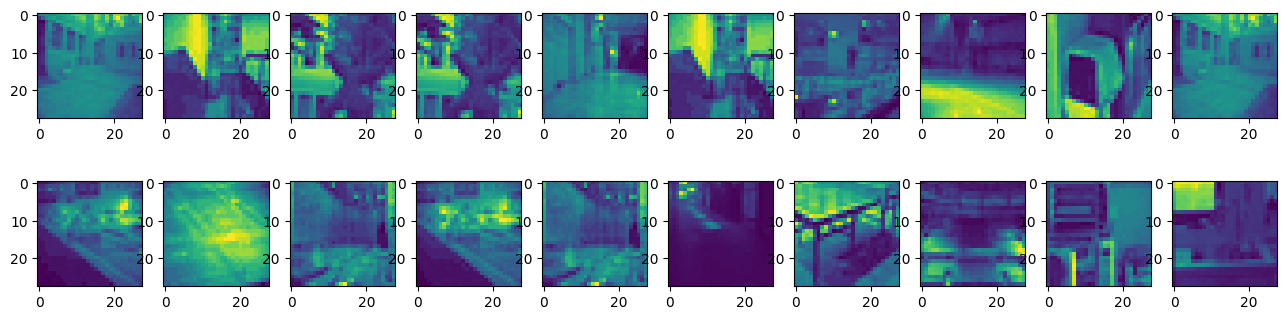

In [270]:
visualize_data(val_dataset_noise[20:40], 2,10)

In [271]:
predicted = autoencoder.predict(val_dataset_noise)
predicted.shape

3/3 [==============================] - 0s 29ms/step


(85, 28, 28, 1)

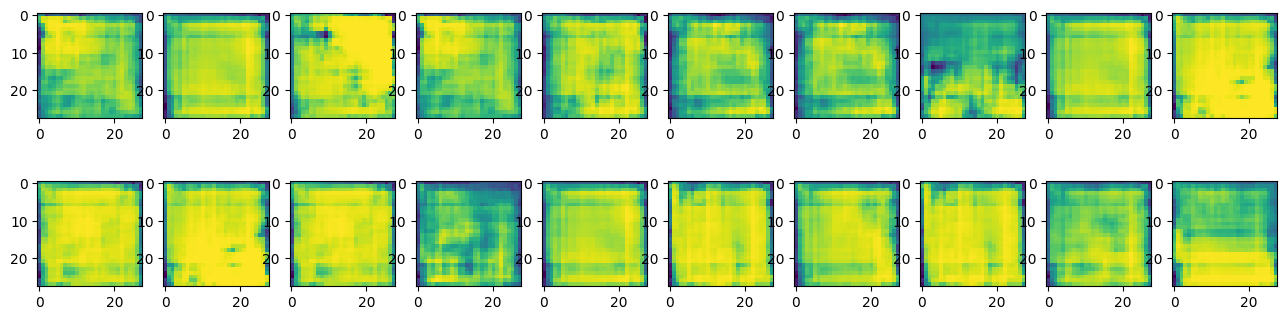

In [272]:
visualize_data(predicted, 2,10)

In [273]:
def PSNR(original, enhanced):
    # height, width , channels= gt.shape
    # gt=cv2.resize(gt, (width//40*40,height//40*40), interpolation=cv2.INTER_CUBIC)
    mse = np.mean((original - enhanced) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(255.0 / (np.sqrt(mse)))

In [275]:
import cv2
sum=0
for i in range(len(val_dataset_noise)):
    # print(PSNR(val_dataset_noise[i],pred[i]))
    sum+=PSNR(val_dataset_noise[i],predicted[i])
print(sum/len(val_dataset_noise))

24.478786425066826
